In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from copy import deepcopy

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
is_training_needed = True
model_name = "ResNet" # valid values: LeNet, ResNet
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [17]:
# Load MNIST data
def load_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, 
                                   download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, 
                                  download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# Load data
BATCH_SIZE = 128
print("\n..... Loading MNIST dataset...")
train_loader, test_loader = load_mnist(BATCH_SIZE)
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


..... Loading MNIST dataset...
Training samples: 60000
Test samples: 10000


In [18]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x, mode=None):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if mode=="Test":
            print("LeNet Forward Testing !!!!!!!!!")
        return x

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x, mode=None):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        if mode=="Test":
            print("ResidualBlock Forward Testing !!!!!!!!!")
        return out

In [20]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(16, 16, 2, stride=1)
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 64, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x, mode=None):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        if mode=="Test":
            print("ResNet Forward Testing !!!!!!!!!")
        return x

In [21]:
def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [22]:
def evaluate_model(model, test_loader, criterion, mode=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data, mode)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [23]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    print(f'Saved training history plot: {model_name}_training_history.png')
    plt.show()

In [24]:
def initial_training(model_name):
    if model_name == 'LeNet': 
        model = LeNet(num_classes=10)
    else:
        model = ResNet(num_classes=10)

        print(f"....... Training {model_name}")

    # Initialize model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Training loop
    print(f"\nTraining {model_name} for {NUM_EPOCHS} epochs...")
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_model(model, train_loader, criterion, 
                                            optimizer, epoch)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f'\nEpoch {epoch}/{NUM_EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%')

    # Final evaluation
    print(f"\n...... Final Evaluation for {model_name}...")
    final_test_loss, final_test_acc = evaluate_model(model, test_loader, criterion)
    print(f"{model_name} - FINAL RESULTS")
    print(f"{'=' * 60}")
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")

    # Save model
    print(f"\n..... Saving {model_name} model...")
    torch.save({
        'epoch': NUM_EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': final_test_loss,
        'test_acc': final_test_acc,
        'history': history
    }, f'{model_name}_mnist.pth')
    print(f"Model saved as: {model_name}_mnist.pth")

    # Plot training history
    print(f"\n....... Plotting training history for {model_name}...")
    plot_history(history, model_name)

In [25]:
def load_model(model_path, model_type='LeNet', device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Loading {model_type} model from {model_path}...")
    
    # Initialize the model architecture
    if model_type == 'LeNet':
        model = LeNet(num_classes=10)
    elif model_type == 'ResNet':
        model = ResNet(num_classes=10)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Use 'LeNet' or 'ResNet'")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Model loaded successfully!")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Test Accuracy: {checkpoint['test_acc']:.2f}%")
    print(f"  - Test Loss: {checkpoint['test_loss']:.4f}")
    
    # checkpoint: Dictionary containing training history and metrics
    return model, checkpoint

....... Training ResNet

Training ResNet for 10 epochs...


Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.44it/s]



Epoch 1/10:
  Train Loss: 0.1856 | Train Acc: 95.36%
  Test Loss:  0.0461 | Test Acc:  98.70%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.50it/s]



Epoch 2/10:
  Train Loss: 0.0436 | Train Acc: 98.72%
  Test Loss:  0.0372 | Test Acc:  98.85%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]



Epoch 3/10:
  Train Loss: 0.0315 | Train Acc: 99.06%
  Test Loss:  0.0687 | Test Acc:  97.88%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.65it/s]



Epoch 4/10:
  Train Loss: 0.0256 | Train Acc: 99.21%
  Test Loss:  0.0311 | Test Acc:  99.00%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.85it/s]



Epoch 5/10:
  Train Loss: 0.0220 | Train Acc: 99.29%
  Test Loss:  0.0198 | Test Acc:  99.33%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.74it/s]



Epoch 6/10:
  Train Loss: 0.0095 | Train Acc: 99.73%
  Test Loss:  0.0138 | Test Acc:  99.47%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.68it/s]



Epoch 7/10:
  Train Loss: 0.0073 | Train Acc: 99.82%
  Test Loss:  0.0124 | Test Acc:  99.51%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.83it/s]



Epoch 8/10:
  Train Loss: 0.0060 | Train Acc: 99.84%
  Test Loss:  0.0128 | Test Acc:  99.55%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]



Epoch 9/10:
  Train Loss: 0.0057 | Train Acc: 99.86%
  Test Loss:  0.0125 | Test Acc:  99.55%


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.13it/s]



Epoch 10/10:
  Train Loss: 0.0046 | Train Acc: 99.88%
  Test Loss:  0.0136 | Test Acc:  99.52%

...... Final Evaluation for ResNet...


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


ResNet - FINAL RESULTS
Final Test Loss: 0.0136
Final Test Accuracy: 99.52%

..... Saving ResNet model...
Model saved as: ResNet_mnist.pth

....... Plotting training history for ResNet...
Saved training history plot: ResNet_training_history.png


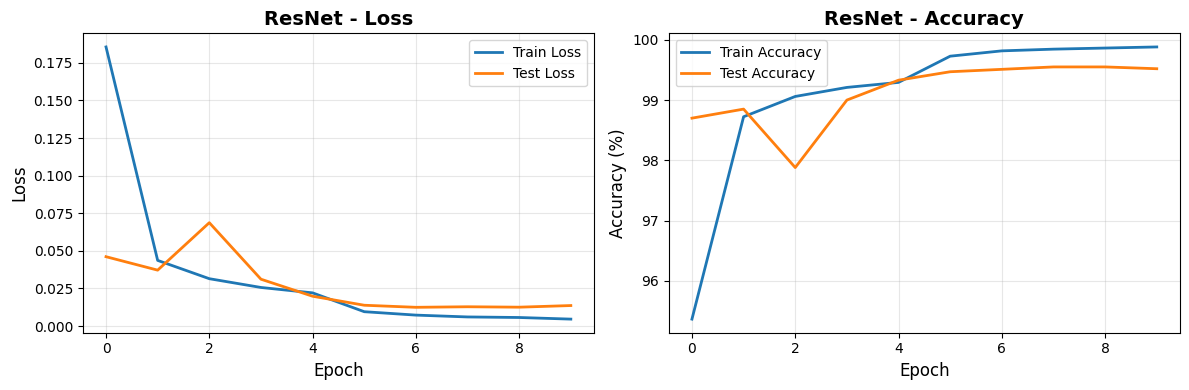

In [26]:

if is_training_needed: 
    initial_training(model_name)

In [27]:
def test_loaded_model(model_path, model_type='LeNet', mode=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    model, checkpoint = load_model(model_path, model_type, device)
    
    # Load test data
    #_, test_loader = load_mnist(batch_size=128)
    
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, mode)
    
    print(f"\nVerification Test:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    
    # Access training history if needed
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"\nTraining History Available:")
        print(f"  - Number of epochs: {len(history['train_loss'])}")
        print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
        print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    
    return model, checkpoint

In [28]:


model_filename = f'{model_name}_mnist.pth'
print("\n------TESTING MODEL -------\n")

lenet_model, lenet_checkpoint = test_loaded_model(model_filename, model_name, mode="Test")

C:\Users\nydor_pt\AppData\Local\Temp\ipykernel_21536\2664528886.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


------TESTING MODEL -------

Loading ResNet model from ResNet_mnist.pth...
✓ Model loaded successfully!
  - Trained for 10 epochs
  - Test Accuracy: 99.52%
  - Test Loss: 0.0136


Evaluating:   5%|▌         | 4/79 [00:05<01:23,  1.11s/it]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  22%|██▏       | 17/79 [00:06<00:10,  5.67it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  37%|███▋      | 29/79 [00:06<00:03, 12.78it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  44%|████▍     | 35/79 [00:06<00:02, 17.33it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  59%|█████▉    | 47/79 [00:06<00:01, 27.86it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  75%|███████▍  | 59/79 [00:06<00:00, 36.00it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  90%|████████▉ | 71/79 [00:07<00:00, 40.70it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating:  97%|█████████▋| 77/79 [00:07<00:00, 42.47it/s]

ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!
ResNet Forward Testing !!!!!!!!!


Evaluating: 100%|██████████| 79/79 [00:08<00:00,  9.78it/s]


Verification Test:
  Test Loss: 0.0136
  Test Accuracy: 99.52%

Training History Available:
  - Number of epochs: 10
  - Best train accuracy: 99.88%
  - Best test accuracy: 99.55%
